In [1]:
import os
import sys

import numpy as np
import torch as th
import torch.nn.functional as F

from motornet.policy import ModularPolicyGRU

from IPython.display import clear_output
import matplotlib.pyplot as plt
from typing import Any

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

%load_ext autoreload
%autoreload 2

import motornet as mn

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)

device = th.device("cpu")
#th.set_default_device(device)

import torch._dynamo.config
torch._dynamo.config.cache_size_limit = 128 

saveLoc = '/Users/jonathanamichaels/Dropbox/torch/'
#saveLoc = '/media/jonathan/Data/Dropbox/torch/'

All packages imported.
pytorch version: 2.2.0.dev20231011
numpy version: 1.25.2
motornet version: 0.2.0


In [2]:
class ExpTask:
    def __init__(self, effector, **kwargs):
        self.effector = effector
        self.dt = self.effector.dt
        self.pre_range = kwargs.get('pre_range', [0.3, 0.3])
        self.c1_range = kwargs.get('c1_range', [0.6, 1.0])
        self.c2_range = kwargs.get('c2_range', [0.6, 1.0])
        self.c3_range = kwargs.get('c3_range', [0.8, 1.6])
        self.size_range = kwargs.get('size_range', [0., 0.02])  # 4cm diameter max
        self.target_size = kwargs.get('target_size', 0.0)
        self.background_load = kwargs.get('background_load', 0.)
        self.run_mode = kwargs.get('run_mode', 'train')
        self.delay_range = [5000, 5000]  # this has to exist to get the size of the inputs

    def generate(self, batch_size, n_timesteps, **kwargs):
        goal_states = self.effector.joint2cartesian(self.effector.draw_random_uniform_states(batch_size=batch_size)).to("cpu").numpy()
        targets = np.tile(np.expand_dims(goal_states, axis=1), (1, n_timesteps, 1))
        prob_array = np.array([0, 0.25, 0.5, 0.75, 1])
        inputs = np.zeros(shape=(batch_size, n_timesteps, 2 + 2 + 2 + 2 + 1 + 1 + 1))
        perturbations = np.zeros(shape=(batch_size, n_timesteps, 2))
        pre_range = self.pre_range
        c1_range = self.c1_range
        c2_range = self.c2_range
        c3_range = self.c3_range
        target_size = self.target_size
        if self.run_mode == 'experiment':
            catch_chance = 0.
            prob_chance = 1.
            go_chance = 0.
            pre_range = [0., 0.]
            c1_range = [0.5, 0.5]
            c2_range = [1., 1.]
            c3_range = [5., 5.]
            target_size = [0.006]  #0.006
        elif self.run_mode == 'train_experiment':
            target_size = [0.006]
            go_chance = 0.
            prob_chance = 1.
            catch_chance = 0.5
        elif self.run_mode == 'train_grow':
            go_chance = 0.25
            catch_chance = 0.5
            prob_chance = 0
        elif self.run_mode == 'train_task':
            go_chance = 0.
            catch_chance = 0.5  # 0.5 best
            prob_chance = 1  # 0.5 best

        base_joint = np.deg2rad([32., 72., 0., 0.]).astype(np.float32)
        center_base = self.effector.joint2cartesian(th.tensor(base_joint)).to("cpu").numpy()
        if self.run_mode == 'experiment' or self.run_mode == 'train_experiment':
            init_states = np.repeat(np.expand_dims(base_joint, axis=0), batch_size, axis=0)
        else:
            init_states = self.effector.draw_random_uniform_states(batch_size).detach().cpu().numpy() #base_joint_rand
        if self.run_mode == 'experiment' or self.run_mode == 'train_experiment':
            background_loads = np.repeat(np.expand_dims(np.array([0, self.background_load]), axis=0),
                                         batch_size, axis=0)
        else:
            background_loads = np.tile([0, self.background_load], [batch_size, 1]) + np.random.uniform(low=-0., high=0., size=(batch_size, 2))
            
        for i in range(batch_size):
            center_joint = init_states[i, :].astype(np.float32)
            center = self.effector.joint2cartesian(th.tensor(center_joint)).to("cpu").numpy()
            # these are our target locations for the experiment version
            #goal_state1 = center + [-0.038749, -0.020890, 0, 0]
            #goal_state2 = center + [0.042140, 0.013495, 0, 0]
            goal_state1 = center  # monkey version
            goal_state2 = center  # monkey version
            c1_time = generate_delay_time(pre_range[0] / self.dt, pre_range[1] / self.dt, 'random')
            c2_time = c1_time + generate_delay_time(c1_range[0] / self.dt, c1_range[1] / self.dt, 'random')
            pert_time = c2_time + generate_delay_time(c2_range[0] / self.dt, c2_range[1] / self.dt, 'random')
            c3_time = pert_time + generate_delay_time(c3_range[0] / self.dt, c3_range[1] / self.dt, 'random')
            if self.run_mode == 'train':
                target_size = np.random.uniform(self.size_range[0], self.size_range[1])
            # cue order not randomized
            targ_time = c1_time
            prob_time = c2_time
            back_time = c3_time
            # is this a catch trial?
            if np.greater_equal(np.random.rand(), catch_chance):
                is_catch = False
            else:
                is_catch = True
                pert_time = inputs.shape[1]
            # is this a probability trial?
            if np.greater_equal(np.random.rand(), prob_chance):
                is_prob_elb = False
            else:
                is_prob_elb = True
            if np.greater_equal(np.random.rand(), prob_chance):
                is_prob_sho = False
            else:
                is_prob_sho = True
            if self.run_mode == 'experiment':
                is_prob_sho = False
            # is this a go cue trial?
            no_prob = False
            if not is_prob_sho and not is_prob_elb:
                no_prob = True
                if np.greater_equal(np.random.rand(), go_chance):
                    is_gocue = False
                else:
                    is_gocue = True
            # Inputs
            if is_prob_elb:
                rand_cue = np.random.randint(0, 5)
                inputs[i, prob_time:, 0] = prob_array[rand_cue]*2 - 1
                inputs[i, prob_time:, 1] = 1
                if self.run_mode == 'experiment':
                    rand_cue = np.random.randint(0, 5)
                elb_prob = prob_array[rand_cue]
            if is_prob_sho:
                rand_cue = np.random.randint(0, 5)
                inputs[i, prob_time:, 2] = prob_array[rand_cue]*2 - 1
                inputs[i, prob_time:, 3] = 1
                if self.run_mode == 'experiment':
                    rand_cue = np.random.randint(0, 5)
                sho_prob = prob_array[rand_cue]
            if self.run_mode == 'experiment' or self.run_mode == 'train_experiment':
                # Targets
                if np.random.rand() < 0.5:
                    targets[i, :, :] = np.tile(np.expand_dims(goal_state1, axis=1), [1, n_timesteps, 1])
                else:
                    targets[i, :, :] = np.tile(np.expand_dims(goal_state2, axis=1), [1, n_timesteps, 1])
            else:
                # Targets
                r = 0.08 * np.sqrt(np.random.rand())
                theta = np.random.rand() * 2 * np.pi
                new_pos = center_base[0, 0:2] + np.expand_dims([r * np.cos(theta), r * np.sin(theta)], axis=0)
                targets[i, :, :] = np.tile(np.expand_dims(self.effector.joint2cartesian(self.effector.draw_random_uniform_states(1)).detach().cpu().numpy(), axis=1),                   [1, n_timesteps, 1])
                #targets[i, :, 0:2] = np.tile(np.expand_dims(new_pos, axis=1), [1, n_timesteps, 1])

            # where we're going
            inputs[i, targ_time:back_time, 4:6] = targets[i, targ_time, 0:2]
            inputs[i, back_time:, 4:6] = center[:, 0:2]
            # where we come from
            inputs[i, :, 6:8] = center[:, 0:2]

            perturbation = np.repeat(np.expand_dims(background_loads[i, :], axis=0), n_timesteps, axis=0)  # background load
            if not is_catch:
                targets[i, 0:pert_time, :] = center
                targets[i, back_time:, :] = center
                if is_prob_elb:
                    if np.random.rand() < elb_prob:
                        perturbation[pert_time:back_time, 1] = background_loads[i, 1] - 0.5
                    else:
                        perturbation[pert_time:back_time, 1] = background_loads[i, 1] + 0.5
                if is_prob_sho:
                    if np.random.rand() < sho_prob:
                        perturbation[pert_time:back_time, 0] = background_loads[i, 0] - 0.5
                    else:
                        perturbation[pert_time:back_time, 0] = background_loads[i, 0] + 0.5
                if no_prob:
                    if is_gocue:
                        inputs[i, pert_time:, 9] = 1.
                    else:
                        perturbation[pert_time:back_time, :] = background_loads[i, :] + np.random.uniform(low=-1, high=1, size=2)
            else:
                targets[i, :, :] = center
  
            # let's tell the network how big the target is
            inputs[i, targ_time:, 8] = target_size

            inputs[i, :, :] = inputs[i, :, :] + np.random.normal(loc=0., scale=1e-3,
                                                                 size=(inputs.shape[1], inputs.shape[2]))
            
            # shift inputs by visual delay
            inputs[i, 10:, :-1] = inputs[i, 0:-10, :-1]
            
            perturbations[i, :, :] = perturbation

        all_inputs = {"inputs": inputs, "joint_load": perturbations}
        return [all_inputs, targets, init_states]

def generate_delay_time(delay_min, delay_max, delay_mode):
    if delay_mode == 'random':
        delay_time = np.random.uniform(delay_min, delay_max)
    elif delay_mode == 'noDelayInput':
        delay_time = 0
    else:
        raise AttributeError

    return int(delay_time)



In [3]:
class ExpTaskEnv(mn.environment.Environment):
  def __init__(self, *args, **kwargs):
    # pass everything as-is to the parent Environment class
    super().__init__(*args, **kwargs)
    self.__name__ = "ExpTask"

  def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None):
    self._set_generator(seed)  # seed the environment and the effector

    options = {} if options is None else options
    batch_size: int = options.get("batch_size", 1)
    joint_state: th.Tensor | np.ndarray | None = options.get("joint_state", None)
    deterministic: bool = options.get("deterministic", False)

    self.effector.reset(options={"batch_size": batch_size, "joint_state": joint_state})
    self.elapsed = 0.
    action = th.zeros((batch_size, self.muscle.n_muscles)).to(self.device)
  
    self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(self.obs_buffer["proprioception"])
    self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
    self.obs_buffer["action"] = [action] * self.action_frame_stacking

    obs = self.get_obs(deterministic=deterministic)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": action,  # no noise here so it is the same
      }
    return obs, info

  def step(self, action, deterministic: bool = False, **kwargs):
    self.elapsed += self.dt

    if deterministic is False:
      noisy_action = self.apply_noise(action, noise=self.action_noise)
    else:
      noisy_action = action
    
    self.effector.step(noisy_action, **kwargs)

    obs = self.get_obs(action=noisy_action)
    reward = None
    truncated = False
    terminated = bool(self.elapsed >= self.max_ep_duration)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": noisy_action,
      }
    return obs, reward, terminated, truncated, info

  def get_proprioception(self):
    mlen = self.states["muscle"][:, 1:2, :] / self.muscle.l0_ce
    mvel = self.states["muscle"][:, 2:3, :] / self.muscle.vmax
    prop = th.concatenate([mlen, mvel], dim=-1).squeeze(dim=1)
    return self.apply_noise(prop, self.proprioception_noise)

  def get_vision(self):
    vis = self.states["fingertip"]
    return self.apply_noise(vis, self.vision_noise)

  def get_obs(self, action=None, deterministic: bool = False):
    self.update_obs_buffer(action=action)

    obs_as_list = [
      self.obs_buffer["vision"][0],  # oldest element
      self.obs_buffer["proprioception"][0],   # oldest element
      ]
    obs = th.cat(obs_as_list, dim=-1)

    if deterministic is False:
       obs = self.apply_noise(obs, noise=self.obs_noise)
    return obs

dt = 0.01
ep_dur = 5.0

mm = mn.muscle.RigidTendonHillMuscle()
ee = mn.effector.RigidTendonArm26(muscle=mm, timestep=dt)
env = ExpTaskEnv(max_ep_duration=ep_dur, effector=ee,
                     proprioception_delay=0.01, vision_delay=0.07,
                     proprioception_noise=1e-3, vision_noise=1e-3, action_noise=1e-4)

env.to(device)
print("Task subclass built.\n")

obs, info = env.reset()

print("obs shape:          ", obs.shape, end="\n\n\n")

for key, val in info.items():
  if type(val) is dict:
    print(key + ": ")
    for k, v in val.items():
      print("\t\t\t" + k + " shape:" + " " * (10-len(k)), v.shape)
  else:
    print(key + " shape:" + " " * (13-len(key)), val.shape)



Task subclass built.

obs shape:           torch.Size([1, 14])


states: 
			joint shape:      torch.Size([1, 4])
			cartesian shape:  torch.Size([1, 4])
			muscle shape:     torch.Size([1, 7, 6])
			geometry shape:   torch.Size([1, 4, 6])
			fingertip shape:  torch.Size([1, 2])
action shape:        torch.Size([1, 6])
noisy action shape:  torch.Size([1, 6])


In [4]:
n_t = int(ep_dur / env.effector.dt)
params = {'pre_range': [0., 0.], 'c1_range': [0.2, 0.7], 'c2_range': [0.8, 1.2], 
          'c3_range': [1.5, 4], 'background_load': -0.05, 'run_mode': 'train_grow'}
task = ExpTask(effector=env.effector, **params)

inputs, targets, init_states = task.generate(1, n_t)

In [5]:
# PFC, PMd, M1, S1, PPC, Spinal
proportion_excitatory = None#[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
vision_mask = [0, 0, 0, 0, 1, 0]
proprio_mask = [0, 0, 0, 0, 0, 1]
task_mask = [0, 0, 0, 0, 1, 0]
c1 = 0.2
c2 = 0.05
c3 = 0.01
c0 = 0.5
connectivity_mask = np.array([[c0, c1, c3, 0, c1, 0],
                              [c1, c0, c1, c3, c1, 0],
                              [c2, c1, c0, c1, c3, c3],
                              [0, 0, c3, c0, c3, c1],
                              [c1, c1, c3, c1, c0, 0],
                              [0, 0, c1, 0, 0, c1]])
connectivity_mask[connectivity_mask > 1] = 1
connectivity_delay = np.zeros_like(connectivity_mask)
output_mask = [0, 0, 0, 0, 0, 1]
module_sizes = [64, 64, 64, 64, 64, 16]
spectral_scaling = 1.
# input sparsity
vision_dim = np.arange(env.get_vision().shape[1])
proprio_dim = np.arange(env.get_proprioception().shape[1]) + vision_dim[-1] + 1
task_dim = np.arange(inputs['inputs'].shape[2]) + proprio_dim[-1] + 1
policy = ModularPolicyGRU(env.observation_space.shape[0] + inputs['inputs'].shape[2], module_sizes, env.n_muscles, 
                vision_dim=vision_dim, proprio_dim=proprio_dim, task_dim=task_dim, 
                vision_mask=vision_mask, proprio_mask=proprio_mask, task_mask=task_mask,
                connectivity_mask=connectivity_mask, output_mask=output_mask, connectivity_delay=connectivity_delay,
                proportion_excitatory=proportion_excitatory, input_gain=1,
                spectral_scaling=spectral_scaling, device=device, activation='tanh')
optimizer = th.optim.Adam(policy.parameters(), lr=3e-3)
scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9999)

train_mode = 'grow'
if train_mode == 'task':
    policy.load_state_dict(th.load(saveLoc + 'weights_grow1'))
    with th.no_grad():
        policy.Wh[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, task_dim[0]:task_dim[1]+1] = th.nn.init.xavier_uniform_(th.Tensor(policy.module_dims[4].shape[0], 2), gain=1)
        policy.Wz[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, task_dim[0]:task_dim[1]+1] = th.nn.init.xavier_uniform_(th.Tensor(policy.module_dims[4].shape[0], 2), gain=1)
        policy.Wr[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, task_dim[0]:task_dim[1]+1] = th.nn.init.xavier_uniform_(th.Tensor(policy.module_dims[4].shape[0], 2), gain=1)
        if True:
            policy.mask_Wh = th.nn.Parameter(th.zeros_like(policy.mask_Wh), requires_grad=False)
            policy.mask_Wh[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, task_dim[0]:task_dim[1]+1] = 1
            #policy.mask_Wh[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, policy.module_dims[4][0]+task_dim[-1]:policy.module_dims[4][-1]+task_dim[-1]+1] = 1
            policy.mask_Wr = th.nn.Parameter(th.zeros_like(policy.mask_Wr), requires_grad=False)
            policy.mask_Wr[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, task_dim[0]:task_dim[1]+1] = 1
            #policy.mask_Wr[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, policy.module_dims[4][0]+task_dim[-1]:policy.module_dims[4][-1]+task_dim[-1]+1] = 1
            policy.mask_Wz = th.nn.Parameter(th.zeros_like(policy.mask_Wz), requires_grad=False)
            policy.mask_Wz[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, task_dim[0]:task_dim[1]+1] = 1
            #policy.mask_Wz[policy.module_dims[4][0]:policy.module_dims[4][-1]+1, policy.module_dims[4][0]+task_dim[-1]:policy.module_dims[4][-1]+task_dim[-1]+1] = 1   
            policy.mask_Y = th.nn.Parameter(th.zeros_like(policy.mask_Y), requires_grad=False)
            policy.mask_bh = th.nn.Parameter(th.zeros_like(policy.mask_bh), requires_grad=False)
            policy.mask_bz = th.nn.Parameter(th.zeros_like(policy.mask_bz), requires_grad=False)
            policy.mask_br = th.nn.Parameter(th.zeros_like(policy.mask_br), requires_grad=False)
            policy.mask_bY = th.nn.Parameter(th.zeros_like(policy.mask_bY), requires_grad=False)

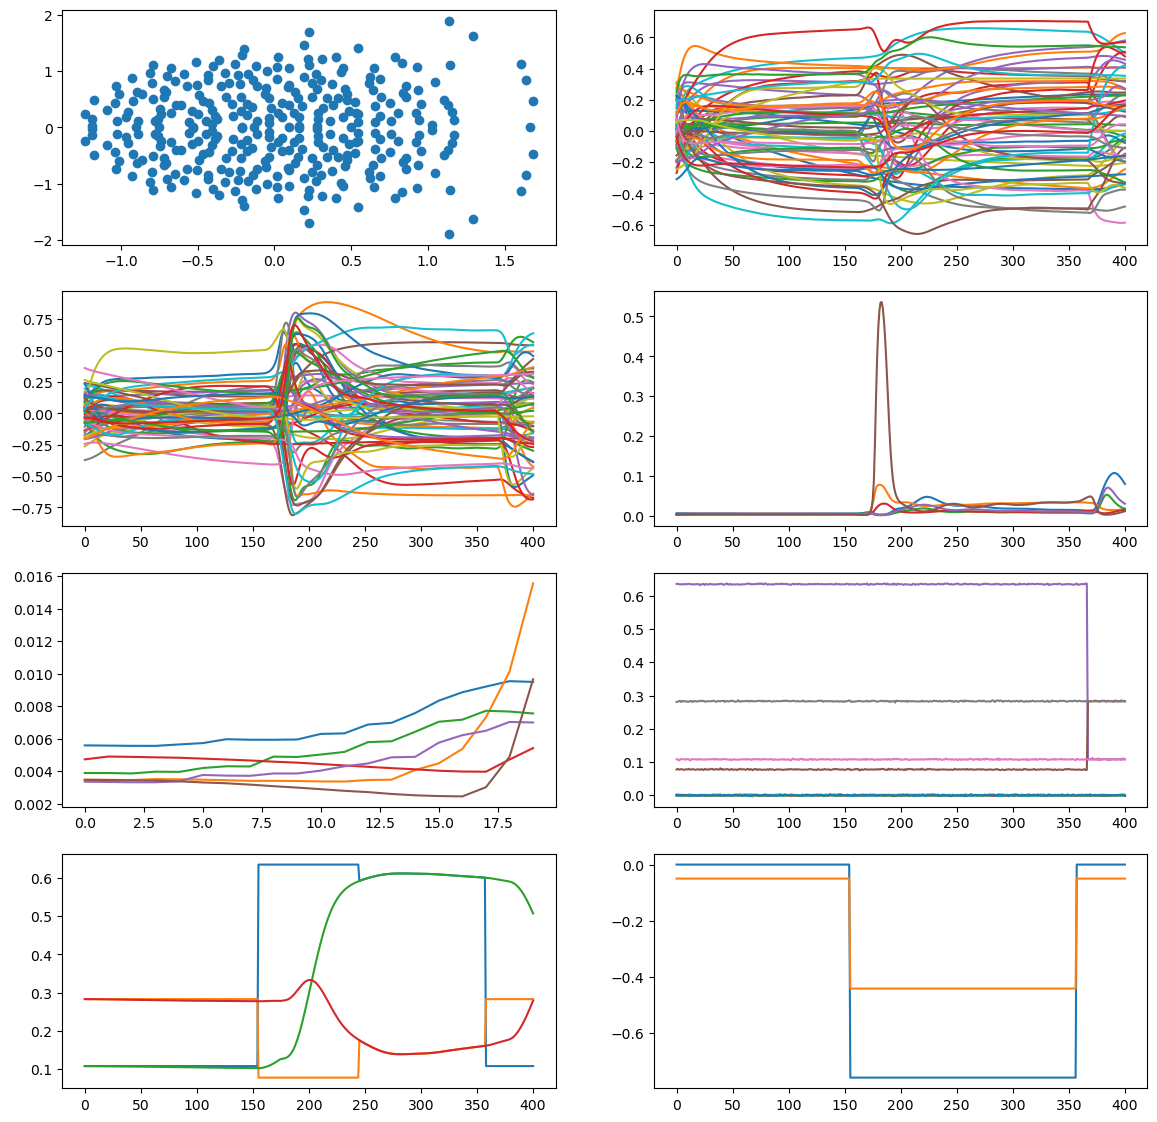

Cartesian:5.3832 Muscle:0.587110937 jerk:0.0105 Spectral:0.2423923 Activity:0.15415 Velocity:1.04980
Batch 2800/10000 Done, total policy loss: 7.4271
[0.002266866038333273]
Cartesian:3.9847 Muscle:0.431788445 jerk:0.0055 Spectral:0.1861462 Activity:0.12282 Velocity:0.71524
Batch 2801/10000 Done, total policy loss: 5.4462
[0.00226663935172944]
Cartesian:8.7963 Muscle:0.578338623 jerk:0.0632 Spectral:0.3881015 Activity:0.15575 Velocity:1.60389
Batch 2802/10000 Done, total policy loss: 11.5856
[0.002266412687794267]
Cartesian:5.0643 Muscle:0.531107783 jerk:0.0097 Spectral:0.2241320 Activity:0.13765 Velocity:1.03582
Batch 2803/10000 Done, total policy loss: 7.0026
[0.002266186046525488]
Cartesian:5.5394 Muscle:0.575292230 jerk:0.0161 Spectral:0.2857118 Activity:0.15090 Velocity:1.11926
Batch 2804/10000 Done, total policy loss: 7.6867
[0.002265959427920835]
Cartesian:5.1806 Muscle:0.596492171 jerk:0.0339 Spectral:0.3285995 Activity:0.15184 Velocity:1.04487
Batch 2805/10000 Done, total polic

In [ ]:

batch_size = 32
n_batch = 10000
losses = []
interval = 50

if train_mode == 'task':
    task.run_mode = 'train_task'
else:
    task.run_mode = 'train_grow'
for batch in range(n_batch):
  ep_dur = np.random.uniform(low=4., high=4.)
  env.max_ep_duration = ep_dur
  n_t = int(ep_dur / env.effector.dt) + 1
  inputs, targets, init_states = task.generate(batch_size, n_t)
  t_g = np.mean(inputs['inputs'][:,:,6], axis=1)
  target_size = th.tensor(np.tile(np.expand_dims(t_g, axis=(1,2)), [1, n_t, 2]), dtype=th.float32).to(device)
  targets = th.tensor(targets[:,:,0:2], device=device, dtype=th.float)
  inp = th.tensor(inputs['inputs'], device=device, dtype=th.float)
  loads = th.tensor(inputs['joint_load'], device=device, dtype=th.float)
  init_states = th.tensor(init_states, device=device, dtype=th.float)
  # initialize batch
  h = policy.init_hidden(batch_size)
  obs, info = env.reset(options={'batch_size': batch_size, 'joint_state': init_states})
  terminated = False

  # initial positions and targets
  xy = []
  all_actions = []
  all_muscle = []
  all_hidden = []
  all_force = []
  all_energy = []
  all_loads  = []
  all_targets = []
  all_inp = []

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    t_step = int(env.elapsed / env.dt)
    obs = th.concat((obs, inp[:,t_step,:]), dim=1)
    
    concat_hidden = th.cat((obs, h), dim=1)
    energy = F.linear(concat_hidden, policy.Wh, th.zeros_like(policy.bh))
    all_energy.append(energy[:, None, :])
    
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action, **{'joint_load': loads[:,t_step,:]})
    xy.append(info['states']['cartesian'][:, None, :])  # trajectories
    all_actions.append(action[:, None, :])
    all_muscle.append(info['states']['muscle'][:,0,None,:])
    all_force.append(info['states']['muscle'][:,-1,None,:])
    all_hidden.append(h[:,None,:])
    all_loads.append(th.unsqueeze(loads[:,t_step,:], dim=1))
    all_targets.append(th.unsqueeze(targets[:,t_step,:], dim=1))
    all_inp.append(th.unsqueeze(inp[:,t_step,:], dim=1))
    
  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  all_hidden = th.cat(all_hidden, axis=1)
  all_actions = th.cat(all_actions, axis=1)
  all_muscle = th.cat(all_muscle, axis=1)
  all_force = th.cat(all_force, axis=1)
  all_energy = th.cat(all_energy, axis=1)
  all_loads = th.cat(all_loads, axis=1)
  all_targets = th.cat(all_targets, axis=1)
  all_inp = th.cat(all_inp, axis=1)

  dist = th.sqrt(th.sum(th.square(xy[:,:,0:2] - all_targets), dim=2))
  temp_loads = th.sum(th.abs(all_loads), dim=2)
  temp_loads_comp = th.tile(th.unsqueeze(temp_loads[:,0], dim=1), [1, temp_loads.shape[1]])
  dist = th.tile(th.unsqueeze(th.where(th.logical_and(temp_loads == temp_loads_comp, all_inp[:,:,7] < 0.5), 1e10, dist), dim=2), [1, 1, 2])
  all_targets = th.where(dist < target_size[:,0:xy.shape[1],:], xy[:,:,0:2], all_targets)
  cartesian_loss = 1e2 * th.mean(th.sum(th.abs(xy[:,:,0:2] - all_targets), dim=-1)) # 1e2 best
  muscle_loss = 1e-2 * th.mean(th.sum(all_force, dim=-1)) # 1e-1 best
  velocity_loss = 10. * th.mean(th.sum(th.abs(xy[:,:,2:]), dim=-1)) # 0. best
  activity_loss = 1e-2 * th.mean(th.sum(th.square(all_hidden), dim=-1)) # 1e-2 best
  Wh_i, Wh = th.split(policy.Wh, [obs.shape[1]+inp.shape[2], h.shape[1]], dim=1)
  Wr_i, Wr = th.split(policy.Wr, [obs.shape[1]+inp.shape[2], h.shape[1]], dim=1)
  Wz_i, Wz = th.split(policy.Wz, [obs.shape[1]+inp.shape[2], h.shape[1]], dim=1)
  
  spectral_loss = ((5e-10 * th.mean(th.sum(th.square(th.diff(all_hidden, 3, dim=1) / th.pow(th.tensor(env.effector.dt), 3)), dim=-1))) + # 2e-10
                   (0 * th.norm(th.matmul(policy.d_hidden(all_hidden), Wh), p='fro') / all_hidden.numel()) + # 1e3
                   (0 * th.mean(th.sum(th.square(th.diff(all_hidden, 1, dim=1)), dim=-1)))) # 10 best
  jerk_loss = 1e-6 * th.mean(th.sum(th.square(th.diff(xy[:,:,2:], 2, 1) / th.square(th.tensor(env.effector.dt))), dim=-1)) # 1e-6 best
  input_loss = 0. * th.mean(th.square(Wh_i) + th.square(Wr_i) + th.square(Wz_i)) # 0 best

  loss = cartesian_loss + muscle_loss + jerk_loss + spectral_loss + activity_loss + velocity_loss
  
  # backward pass & update weights
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())
  scheduler.step()
  optimizer.zero_grad()
  #policy.enforce_dale(zero_out=True)
  print(scheduler.get_last_lr())

  if (batch % interval == 0):
      clear_output(wait=True)
      fg, ax = plt.subplots(nrows=4,ncols=2)
      fg.set_figwidth(14)
      fg.set_figheight(14)
      ind = np.where((loads[:,0,1] - loads[:,-150,1]).detach().cpu().numpy() != 0)[0][0]
      dd = np.diff(loads[ind,:,1].detach().cpu().numpy(),1)
      i_p = (dd != 0).argmax()
      Wh = policy.Wh.detach().cpu().numpy()[:,task_dim[-1]+1:]
      E = th.linalg.eigvals(th.Tensor(Wh)).detach().numpy()
      ax[0,0].scatter(np.real(E), np.imag(E))
      #ax[0,0].plot(np.transpose(np.squeeze(all_hidden.detach().cpu().numpy()[ind,:,policy.module_dims[0]])))
      ax[0,1].plot(np.transpose(np.squeeze(all_hidden.detach().cpu().numpy()[ind,:,policy.module_dims[4]])))
      ax[1,0].plot(np.transpose(np.squeeze(all_hidden.detach().cpu().numpy()[ind,:,policy.module_dims[1]])))
      ax[1,1].plot(np.squeeze(all_actions.detach().cpu().numpy()[ind,:,:]))
      ax[2,0].plot(np.squeeze(all_muscle.detach().cpu().numpy()[ind,i_p: i_p + 20,:]))
      ax[2,1].plot(np.squeeze(inp.detach().cpu().numpy()[ind,:,:]))
      ax[3,0].plot(np.concatenate((all_targets.detach().cpu().numpy()[ind,:,0:2], xy.detach().cpu().numpy()[ind,:,0:2]), axis=1))
      #ax[3,1].plot(ff.detach().numpy())
      ax[3,1].plot(loads.detach().cpu().numpy()[ind,:,:])
      #mn.plotor.plot_pos_over_time(xy[:,:,0:2].cpu().detach(), ax[5])
      plt.show()
      th.save(policy.state_dict(), saveLoc + 'weights')
  print("Cartesian:{:.4f} Muscle:{:.9f} jerk:{:.4f} Spectral:{:.7f} Activity:{:.5f} Velocity:{:.5f}".format(cartesian_loss.detach().cpu(), muscle_loss.detach().cpu(), jerk_loss.detach().cpu(), spectral_loss.detach().cpu(), activity_loss.detach().cpu(), velocity_loss.detach().cpu()))
  print("Batch {}/{} Done, total policy loss: {:.4f}".format(batch, n_batch, losses[-1]))

In [ ]:
task.run_mode = 'experiment'
batch_size = 2000
ep_dur = 3.
env.max_ep_duration = ep_dur
n_t = int(ep_dur / env.effector.dt) + 1
inputs, targets, init_states = task.generate(batch_size, n_t)
targets = th.tensor(targets[:,:,0:2], device=device, dtype=th.float)
inp = th.tensor(inputs['inputs'], device=device, dtype=th.float)
loads = th.tensor(inputs['joint_load'], device=device, dtype=th.float)
init_states = th.tensor(init_states, device=device, dtype=th.float)
# initialize batch
h = policy.init_hidden(batch_size)
obs, info = env.reset(options={'batch_size': batch_size, 'joint_state': init_states})
terminated = False

# initial positions and targets
xy = []
all_actions = []
all_muscle = []
all_hidden = []
all_joint = []
all_vision = []
all_proprio = []

# simulate whole episode
while not terminated:  # will run until `max_ep_duration` is reached
    t_step = int(env.elapsed / env.dt)
    obs = th.concat((obs, inp[:,t_step,:]), dim=1)
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action, **{'joint_load': loads[:,t_step,:]})
    xy.append(info['states']['cartesian'][:, None, :])  # trajectories
    all_joint.append(info['states']['joint'][:, None, :])  # trajectories
    all_vision.append(obs[:, None, vision_dim])
    all_proprio.append(obs[:, None, proprio_dim])
    all_actions.append(action[:, None, :])
    all_muscle.append(info['states']['muscle'][:,0,None,:])
    all_hidden.append(h[:,None,:])

# concatenate into a (batch_size, n_timesteps, xy) tensor
xy = th.cat(xy, axis=1)
all_hidden = th.cat(all_hidden, axis=1)
all_actions = th.cat(all_actions, axis=1)
all_muscle = th.cat(all_muscle, axis=1)
all_proprio = th.cat(all_proprio, axis=1)
all_vision = th.cat(all_vision, axis=1)
all_joint = th.cat(all_joint, axis=1)

In [ ]:
import scipy.io
toSave = {'joint': all_joint.detach().numpy(),
                          'cartesian': xy.detach().numpy(),
                          'muscle': all_muscle.detach().numpy(),
                          'inputs': inputs["inputs"],
                          'targets': targets.detach().numpy(),
                          'joint_load': inputs["joint_load"],
                          'neural': all_hidden.detach().numpy(),
                          'proprio': all_proprio.detach().numpy(),
                          'visual': all_vision.detach().numpy(),
                          'module_dims': policy.module_dims,
                          'Wz': policy.Wz.detach().numpy(),
          'Wr': policy.Wr.detach().numpy(),
          'Wh': policy.Wh.detach().numpy(),
          'Y': policy.Y.detach().numpy(),
          'losses': losses
          }
scipy.io.savemat(saveLoc + 'results.mat', toSave)
th.save(policy.state_dict(), saveLoc + 'weights')

In [ ]:
inputs['inputs'].shape
ii = 0
fg, ax = plt.subplots(nrows=3,ncols=1)
ax[0].plot(inputs['inputs'][ii,:,:])
ax[1].plot(inputs['joint_load'][ii,:,:])
ax[2].plot(targets[ii,:,:])

In [ ]:
ii = 3
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(np.concatenate((targets.detach().cpu().numpy()[ii,:,:], xy.detach().cpu().numpy()[ii,:,0:2]), axis=1))

In [ ]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  #axs.semilogy(log)
  axs.plot(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

In [ ]:
ii = 0
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(all_muscle.detach().cpu().numpy()[ii,:,:])
ax[1].plot(all_muscle.detach().cpu().numpy()[ii+1,:,:])

In [ ]:
ii = 0
m = 0
fg, ax = plt.subplots(nrows=2,ncols=1)
h = np.squeeze(all_hidden.detach().cpu().numpy()[ii : ii+2,:,policy.module_dims[m]])
ax[0].plot(h[0,:,:])
ax[1].plot(h[1,:,:])
print(h.shape)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(policy.mask_Wr.detach().cpu().numpy(), aspect='equal', interpolation='none', cmap=plt.cm.Greys)
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
Wh = policy.Wh.detach().cpu().numpy()[:,task_dim[-1]+1:]
plt.imshow(Wh, aspect='equal', interpolation='none', cmap=plt.cm.spring)
plt.show()
plt.figure(figsize=(6,4))
E = th.linalg.eigvals(th.Tensor(Wh)).detach().numpy()
plt.scatter(np.real(E), np.imag(E))
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
Wr = policy.Wr.detach().cpu().numpy()
plt.imshow(Wr, aspect='equal', interpolation='none')
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
plt.imshow(policy.Wz.detach().cpu().numpy(), aspect='equal', interpolation='none')
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
plt.imshow(policy.Y.detach().cpu().numpy(), aspect='auto', interpolation='none')
plt.show()

In [ ]:
th._dynamo.list_backends()